# Predicting the high school marks of a set of portuguese students usind deep learning technics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import InputLayer
from keras import backend as k
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
seed=42
kf=4

In [3]:
XY_train=pd.read_excel('X10Y10_CONC.xlsx')

In [4]:
LassoFeatToDrop =['Student_Internet', 'Student_ActiveWorking', 'Student_Parish',
       'FTH_Nation_CHN', 'FTH_Nation_EEUR', 'FTH_Nation_OTHERS',
       'FTH_Nation_RICH', 'SES_STDRESP_ProfClass_UnivII',
       'SES_STDRESP_ProfClass_Unknown_NoProfession',
       'SES_FATH_ProfClass_Unknown_NoProfession', 'SES_MOTH_ProfClass_BasicI',
       'SES_MOTH_ProfClass_UnivI', 'SES_MOTH_ProfClass_Unknown_NoProfession',
       'SES_STDRESP_JobSit_HomeAffairs', 'SES_STDRESP_JobSit_Other',
       'SES_STDRESP_JobSit_Retired', 'SES_STDRESP_JobSit_Student',
       'SES_STDRESP_JobSit_Unemployed', 'SES_STDRESP_JobSit_Unknown',
       'SES_FATH_JobSit_Employer', 'SES_FATH_JobSit_HomeAffairs',
       'SES_FATH_JobSit_Other', 'SES_FATH_JobSit_Retired',
       'SES_FATH_JobSit_Student', 'SES_FATH_JobSit_Unknown',
       'SES_MOTH_JobSit_HomeAffairs', 'SES_MOTH_JobSit_Other',
       'SES_MOTH_JobSit_SelfEmployed', 'SES_MOTH_JobSit_Unemployed',
       'SES_MOTH_JobSit_Unknown', 'SES_STDRESP_AcadEduc_Basic_II',
       'SES_STDRESP_AcadEduc_Basic_III', 'SES_STDRESP_AcadEduc_PostGraduation',
       'SES_STDRESP_AcadEduc_Unknown', 'SES_FATH_AcadEduc_Bachelor',
       'SES_FATH_AcadEduc_NoFormalEducation', 'SES_FATH_AcadEduc_Other',
       'SES_FATH_AcadEduc_PostGraduation', 'SES_FATH_AcadEduc_Unknown',
       'SES_MOTH_AcadEduc_Bachelor', 'SES_MOTH_AcadEduc_NoFormalEducation',
       'SES_MOTH_AcadEduc_Other', 'SES_MOTH_AcadEduc_Unknown',
       'SES%_Parish_IliteracyRate', 'SES%_Parish_PostSecondarySchoolingRate',
       'SES%_Parish_PrimarySector', 'Tch_FixedTermStaff',
       'Tch_PedagogicZoneNoDefinitivePermanentStaff',
       'Tch_SchoolClusterNoDefinitivePermanentStaff',
       'Tch_SchoolNoDefinitivePermanentStaff', 'Tch_AcadEduc_Phd_Master',
       'Teacher_TemporaryReplacement', 'Teacher_EducationSupport',
       'Teacher_Age', 'Teacher_TeachingDedicatedTime',
       'Teacher_NoTeachingDedicatedTime']

In [5]:
XY_train=XY_train.drop(LassoFeatToDrop, axis=1)

In [6]:
XY_train=XY_train.drop(['Unnamed: 0', 'AcYear_11', 'AcYear_12'], axis=1)

In [7]:
XY_train.shape

(32706, 65)

In [8]:
X_train=XY_train.iloc[:,:64]
Y_train=XY_train.iloc[:,-1]

In [9]:

Y_train=Y_train.to_numpy()

In [10]:
# standardization
scaler=StandardScaler()

## Search Grid CV: ANN

In [11]:
def r2(y_true,y_pred):
    SS_res=k.sum(k.square(y_true-y_pred))
    SS_tot=k.sum(k.square(y_true-k.mean(y_true)))
    return (1-SS_res/(SS_tot+k.epsilon()))

# define base model
def baseline_model(input_dim=64,output_dim=1, init='glorot_uniform', layers=[16,16], activ_function='relu',
                   optim='adam' , loss_function='mse'):
    # ,Adam_lr=0.001, Adam_beta1=0.9, Adam_beta2=0.999, Adam_epsilon=1e-07
    # create model
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(units=nodes, input_dim=input_dim, kernel_initializer=init, activation=activ_function))
        else:
            model.add(Dense(units=nodes, kernel_initializer=init, activation=activ_function))
    model.add(Dense(units=output_dim, kernel_initializer=init,))
    # Compile model
    # optim_m=Adam(learning_rate=Adam_lr, beta_1=Adam_beta1, beta_2=Adam_beta2, epsilon= Adam_epsilon)
    model.compile(optimizer=optim, loss=loss_function, metrics=['mae','mse',r2])
    return model

In [12]:
np.random.seed(seed)

In [13]:
# Define sklearn-like estimator
keras_estimator=KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=32, verbose=1)

In [14]:
# Define sklearn pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('kr', keras_estimator))
pipeline = Pipeline(estimators)

In [15]:
pipeline.get_params()

{'memory': None,
 'steps': [('standardize',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('kr', <keras.wrappers.scikit_learn.KerasRegressor at 0x176f3c98608>)],
 'verbose': False,
 'standardize': StandardScaler(copy=True, with_mean=True, with_std=True),
 'kr': <keras.wrappers.scikit_learn.KerasRegressor at 0x176f3c98608>,
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'kr__epochs': 10,
 'kr__batch_size': 32,
 'kr__verbose': 1,
 'kr__build_fn': <function __main__.baseline_model(input_dim=64, output_dim=1, init='glorot_uniform', layers=[16, 16], activ_function='relu', optim='adam', loss_function='mse')>}

{'kr__activ_function': 'relu',
 'kr__batch_size': 32,
 'kr__epochs': 50,
 'kr__input_dim': 122,
 'kr__layers': (24, 24),
 'kr__optim': 'adam'}

In [27]:
dim_input=64
# [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# [14, 21, 28, 35, 42, 49, 56, 63]

layers=[(14,14,14,14,14,14,14), (14,14,14,14,14,14,14,14), (14,14,14,14,14,14,14,14,14), (14,14,14,14,14,14,14,14,14,14),
        (7,7,7,7,7,7,7), (7,7,7,7,7,7,7,7), (7,7,7,7,7,7,7,7,7), (7,7,7,7,7,7,7,7,7,7),
       (10,10,10,10,10,10,10), (10,10,10,10,10,10,10,10), (10,10,10,10,10,10,10,10,10), (10,10,10,10,10,10,10,10,10,10)]

In [28]:
# Define hyperparameters space


param_grid={'kr__layers': layers}
            
            #[(24,24),(36,36),(48,48),(60,60),(72,72),(84,84),(96,96),(108,108)],
            #'kr__activ_function': ['relu'],# 'sigmoid'
            #'kr__optim': ['adam']#,'sgd'

In [29]:
scaler.fit(X_train)
X_train_std=scaler.transform(X_train)

In [30]:
# Grid_Search
grid=RandomizedSearchCV(pipeline,param_grid,
                        n_jobs=-1, cv=kf, n_iter=200,
                        verbose=1, scoring='neg_mean_absolute_error', return_train_score=True)
# scoring='r2'
# keras_estimator, param_grid_keras

In [31]:
# Grid search
grid_result=grid.fit(X_train, Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=200. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 12 candidates, totalling 48 fits


C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  6.5min finished


Epoch 1/10
32706/32706 [==============================] - 3s 94us/step - loss: 21.1111 - mae: 3.1967 - mse: 21.1111 - r2: -1.9463
Epoch 2/10
32706/32706 [==============================] - 2s 75us/step - loss: 6.8172 - mae: 2.1160 - mse: 6.8172 - r2: 0.0559
Epoch 3/10
32706/32706 [==============================] - 3s 77us/step - loss: 6.5737 - mae: 2.0824 - mse: 6.5737 - r2: 0.0920 0s - loss: 6.5497 - mae: 2.0800 - 
Epoch 4/10
32706/32706 [==============================] - 3s 77us/step - loss: 6.4897 - mae: 2.0696 - mse: 6.4897 - r2: 0.0988
Epoch 5/10
32706/32706 [==============================] - 3s 77us/step - loss: 6.4513 - mae: 2.0648 - mse: 6.4513 - r2: -60896.2227
Epoch 6/10
32706/32706 [==============================] - 3s 78us/step - loss: 6.4189 - mae: 2.0597 - mse: 6.4189 - r2: 0.1154
Epoch 7/10
32706/32706 [==============================] - 2s 72us/step - loss: 6.4049 - mae: 2.0556 - mse: 6.4049 - r2: 0.1121
Epoch 8/10
32706/32706 [==============================] - 2s 74us/st

In [32]:
# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means=grid_result.cv_results_['mean_test_score']
stds=grid_result.cv_results_['std_test_score']
params=grid_result.cv_results_['params']

for mean, stdev, param in zip(means,stds, params):
    print ("%f (%f) with: %r" % (mean,stdev,param))


Best: -2.063097 using {'kr__layers': (10, 10, 10, 10, 10, 10, 10, 10)}
-2.074870 (0.017150) with: {'kr__layers': (14, 14, 14, 14, 14, 14, 14)}
-2.071806 (0.014890) with: {'kr__layers': (14, 14, 14, 14, 14, 14, 14, 14)}
-2.064266 (0.011538) with: {'kr__layers': (14, 14, 14, 14, 14, 14, 14, 14, 14)}
-2.074368 (0.011896) with: {'kr__layers': (14, 14, 14, 14, 14, 14, 14, 14, 14, 14)}
-2.065467 (0.008882) with: {'kr__layers': (7, 7, 7, 7, 7, 7, 7)}
-2.072090 (0.009633) with: {'kr__layers': (7, 7, 7, 7, 7, 7, 7, 7)}
-2.081464 (0.019348) with: {'kr__layers': (7, 7, 7, 7, 7, 7, 7, 7, 7)}
-2.072540 (0.017207) with: {'kr__layers': (7, 7, 7, 7, 7, 7, 7, 7, 7, 7)}
-2.069656 (0.012716) with: {'kr__layers': (10, 10, 10, 10, 10, 10, 10)}
-2.063097 (0.008951) with: {'kr__layers': (10, 10, 10, 10, 10, 10, 10, 10)}
-2.067177 (0.012850) with: {'kr__layers': (10, 10, 10, 10, 10, 10, 10, 10, 10)}
-2.065075 (0.008471) with: {'kr__layers': (10, 10, 10, 10, 10, 10, 10, 10, 10, 10)}


In [33]:
grid_result.best_estimator_.named_steps['kr'].model.history.history
# grid_result.best_estimator_.model.history.history

{'loss': [21.111058612310988,
  6.817218068979614,
  6.573708933952321,
  6.489735965312369,
  6.451284480198424,
  6.41892783946381,
  6.404871467653782,
  6.3872252698849445,
  6.360308281356083,
  6.354960178196091],
 'mae': [3.1966655,
  2.1159737,
  2.0824153,
  2.0695794,
  2.0648077,
  2.0597146,
  2.0555696,
  2.0534675,
  2.0491772,
  2.0486202],
 'mse': [21.111069,
  6.8172226,
  6.573712,
  6.4897327,
  6.451285,
  6.4189243,
  6.4048758,
  6.387225,
  6.360313,
  6.35496],
 'r2': [-1.9463066,
  0.055903815,
  0.09200089,
  0.09880665,
  -60896.223,
  0.115377836,
  0.1121216,
  0.11698264,
  -98351.47,
  0.12163986]}

In [34]:
df_resgscv_ann=pd.DataFrame(grid_result.cv_results_)

In [35]:
# df_resgscv_ann.to_excel('HYPER_RESULTS_II_ANN.xlsx', sheet_name='ANN_CV_Topology')

with pd.ExcelWriter('HYPER_RESULTS_II_ANN.xlsx',engine='openpyxl', mode='a') as writer:
    df_resgscv_ann.to_excel(writer, sheet_name='ANN_CV_Topology_2')

In [36]:
df_resgscv_ann.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kr__layers,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,21.714883,0.143231,0.215414,0.012722,"(14, 14, 14, 14, 14, 14, 14)","{'kr__layers': (14, 14, 14, 14, 14, 14, 14)}",-2.104073,-2.069836,-2.064546,-2.061025,-2.074870,0.017150,11,-2.029149,-2.015146,-2.006528,-2.013329,-2.016038,0.008223
1,25.055273,0.203501,0.364795,0.021486,"(14, 14, 14, 14, 14, 14, 14, 14)","{'kr__layers': (14, 14, 14, 14, 14, 14, 14, 14)}",-2.088075,-2.075655,-2.075975,-2.047518,-2.071806,0.014890,7,-2.020053,-2.023872,-2.009289,-2.018338,-2.017888,0.005354
2,28.468608,0.131771,0.406669,0.014351,"(14, 14, 14, 14, 14, 14, 14, 14, 14)","{'kr__layers': (14, 14, 14, 14, 14, 14, 14, 14...",-2.075413,-2.057548,-2.075342,-2.048760,-2.064266,0.011538,2,-2.019712,-2.013493,-2.013944,-2.007820,-2.013742,0.004208
3,30.229995,0.128969,0.546567,0.015465,"(14, 14, 14, 14, 14, 14, 14, 14, 14, 14)","{'kr__layers': (14, 14, 14, 14, 14, 14, 14, 14...",-2.086262,-2.055194,-2.074107,-2.081909,-2.074368,0.011896,10,-2.035967,-2.014842,-2.010340,-2.038743,-2.024973,0.012522
4,26.491048,0.223464,0.778584,0.076905,"(7, 7, 7, 7, 7, 7, 7)","{'kr__layers': (7, 7, 7, 7, 7, 7, 7)}",-2.075659,-2.059203,-2.072579,-2.054427,-2.065467,0.008882,4,-2.031535,-2.035337,-2.034198,-2.039804,-2.035218,0.002985


In [37]:
grid_result.best_params_

{'kr__layers': (10, 10, 10, 10, 10, 10, 10, 10)}

## A simple Fit keras model

In [38]:
model=baseline_model(input_dim=64,output_dim=1,layers=[10, 10, 10, 10, 10, 10, 10, 10], activ_function='relu',
                  optim='adam', loss_function='mse')


In [39]:
# Fit the model
history = model.fit(X_train_std, Y_train, validation_split=0.30, epochs=200, batch_size=32, verbose=0)

In [40]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_mae', 'val_mse', 'val_r2', 'loss', 'mae', 'mse', 'r2'])


In [41]:
df_history=pd.DataFrame(history.history)

In [42]:
df_history.head(50)

,val_loss,val_mae,val_mse,val_r2,loss,mae,mse,r2
0,7.394650,2.188087,7.394653,-0.028736,24.116588,3.462678,24.116577,-2.393258
1,6.782673,2.105552,6.782673,0.061232,6.964712,2.137739,6.964710,0.037435
2,6.605295,2.082415,6.605295,0.085056,6.631999,2.091720,6.631998,0.087634
3,6.683074,2.095636,6.683074,0.072533,6.525458,2.076225,6.525455,0.104866
4,6.628310,2.090298,6.628309,0.081273,6.475766,2.069512,6.475768,0.106336
5,6.525681,2.063749,6.525681,0.096867,6.450316,2.063498,6.450316,0.110555
6,6.481568,2.062818,6.481569,0.103514,6.411558,2.055654,6.411560,0.115616
7,6.513984,2.068524,6.513984,0.097853,6.374697,2.053025,6.374697,0.124846
8,6.454195,2.059361,6.454197,0.108215,6.362562,2.049122,6.362563,0.124271
9,6.463131,2.062120,6.463130,0.105265,6.367120,2.050142,6.367116,0.122379


In [43]:
# df_history.to_excel('HYPER_ANN.xlsx', sheet_name='ANN_1616_CV')

# with pd.ExcelWriter('HYPER_ANN.xlsx',engine='openpyxl', mode='a') as writer:
  #   df_history.to_excel(writer, sheet_name='ANN_737373_CV')

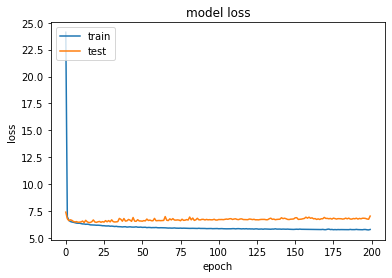

In [44]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

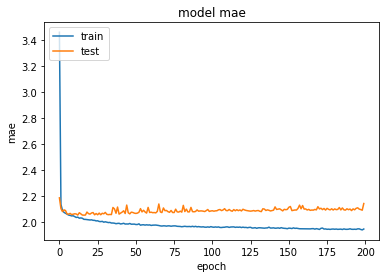

In [45]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

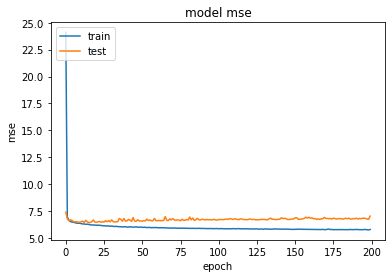

In [46]:
# summarize history for mse
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_20 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_21 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_22 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_23 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_24 (Dense)             (None, 10)               

## Mauro cross validation implementation Keras deep learning

In [ ]:
num_epochs=50
batch=32
k=4
num_val_samples=len(X_train)//k #Floor division - division that results into whole number
#adjusted to the left in the number line
all_mae_histories=[]


In [ ]:
for i in range(k):
    #Prepares the validation data: data from partition #k
    print('Processing fold #', i)
    val_data=X_train[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=Y_train[i*num_val_samples:(i+1)*num_val_samples]
    #Prepares the training data: data from all other partitions
    partial_train_data=np.concatenate([X_train[:i*num_val_samples],
        X_train[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets=np.concatenate([Y_train[:i*num_val_samples],
        Y_train[(i+1)*num_val_samples:]], axis=0)
    # builds the keras model already compiled
    if j==1:
        model=baseline_model(input_dim=122,output_dim=1,layers=[73,73,73], activ_function='relu',
                  optim='adam', loss_function='mse')
    else:
        model=baseline_model(input_dim=122,output_dim=1,layers=[16,16], activ_function='relu',
                  optim='adam', loss_function='mse')
    # trains the model in silent mode
    scaler.fit(partial_train_data)
    partial_train_data_std=scaler.transform(partial_train_data)
    val_data_std=scaler.transform(val_data)
    history = model.fit(partial_train_data_std, partial_train_targets,validation_data=(val_data_std,val_targets),
                        epochs=num_epochs,batch_size=batch,verbose=0)
    #Evaluates the model on the validation data
    mae_history=history.history['val_mae']
    all_mae_histories.append(mae_history)

In [ ]:
df_cv_ann=pd.DataFrame(all_mae_histories)
# df_cv_ann.to_excel('TOPOLOGY_ANN.xlsx', sheet_name='ANN_1616_CV')

#with pd.ExcelWriter('TOPOLOGY_ANN.xlsx',engine='openpyxl', mode='a') as writer:
 #   df_cv_ann.to_excel(writer, sheet_name='ANN_737373_CV')

In [ ]:
# all_mae_histories has 4 arrays with 50 elements (50 means of 4 values)
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [ ]:
len(average_mae_history)

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [ ]:
def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [ ]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
if j==1:
        model=baseline_model(input_dim=122,output_dim=1,layers=[73,73,73], activ_function='relu',
                  optim='adam', loss_function='mse')
else:
        model=baseline_model(input_dim=122,output_dim=1,layers=[16,16], activ_function='relu',
                  optim='adam', loss_function='mse')

model.fit(X_train_std, Y_train, epochs=50,batch_size=32, verbose=0)

In [ ]:
print(model.metrics_names)

In [ ]:
X_test_std=scaler.transform(X_test)
loss_test, mae_test, mse_test = model.evaluate(X_test_std, Y_test)

In [ ]:
mse_test # [16,16]:6.352896213531494/[16,16,16] 6.277432441711426